In [31]:
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda')
#DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')  
#DEVICE=torch.device('cpu')

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
image_path = "/kaggle/input/cat-and-dog"
walk_through_dir(image_path)

train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
test_dir = "/kaggle/input/cat-and-dog/test_set/test_set"
train_dir, test_dir

There are 2 directories and 0 images in '/kaggle/input/cat-and-dog'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/test_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/test_set/test_set'.
There are 0 directories and 1013 images in '/kaggle/input/cat-and-dog/test_set/test_set/dogs'.
There are 0 directories and 1012 images in '/kaggle/input/cat-and-dog/test_set/test_set/cats'.
There are 1 directories and 0 images in '/kaggle/input/cat-and-dog/training_set'.
There are 2 directories and 0 images in '/kaggle/input/cat-and-dog/training_set/training_set'.
There are 0 directories and 4006 images in '/kaggle/input/cat-and-dog/training_set/training_set/dogs'.
There are 0 directories and 4001 images in '/kaggle/input/cat-and-dog/training_set/training_set/cats'.


('/kaggle/input/cat-and-dog/training_set/training_set',
 '/kaggle/input/cat-and-dog/test_set/test_set')

In [33]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize (
    mean=[0.485,0.456,0.406],
    std=[0.229,0.224,0.225]
    )               
])

In [34]:
train_data=ImageFolder(train_dir,transform=transformations)
test_data=ImageFolder(test_dir,transform=transformations)

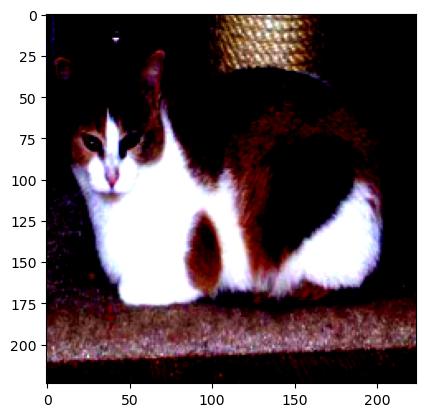

In [35]:
plt.imshow((train_data[100][0]).permute(1,2,0))

In [36]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1)

        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)

        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)

        self.pool3 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()

        self.fc1= nn.Linear(128*28*28,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3= nn.Linear(128,1)

    def forward(self,x):
        out=self.pool1(F.relu(self.conv1(x)))
        out=self.pool2(F.relu(self.conv2(out)))
        out=self.pool3(F.relu(self.conv3(out)))

        out=self.flatten(out)

        out=F.relu(self.fc1(out))
        out=F.relu(self.fc2(out))
        out=torch.sigmoid(self.fc3(out))

        return out

In [37]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):

    #Initializing two lists to save accuracy to plot them later
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #Going thru every epoch
    for epoch in range(n_epochs):

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(output, labels.float())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
            
            
        with torch.no_grad():
            
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total
                
        print(f'Epoch {epoch+1})', 
              f'Train Accuracy: {train_accuracy[epoch]}',
              f'Test Accuracy: {test_accuracy[epoch]}')

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(n_epochs)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [38]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle =True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle =True)

Epoch 1) Train Accuracy: 0.6560899019241333 Test Accuracy: 0.6510133147239685
Epoch 2) Train Accuracy: 0.760649561882019 Test Accuracy: 0.7197231650352478
Epoch 3) Train Accuracy: 0.8523422479629517 Test Accuracy: 0.7394957542419434
Epoch 4) Train Accuracy: 0.929169237613678 Test Accuracy: 0.7414730191230774
Epoch 5) Train Accuracy: 0.991130530834198 Test Accuracy: 0.7325753569602966
Epoch 6) Train Accuracy: 0.9920049905776978 Test Accuracy: 0.7221947312355042
Epoch 7) Train Accuracy: 0.9900062084197998 Test Accuracy: 0.7207117676734924
Epoch 8) Train Accuracy: 0.994503378868103 Test Accuracy: 0.735046923160553
Epoch 9) Train Accuracy: 0.9983760118484497 Test Accuracy: 0.7409787178039551
Epoch 10) Train Accuracy: 0.9953778386116028 Test Accuracy: 0.7340582609176636


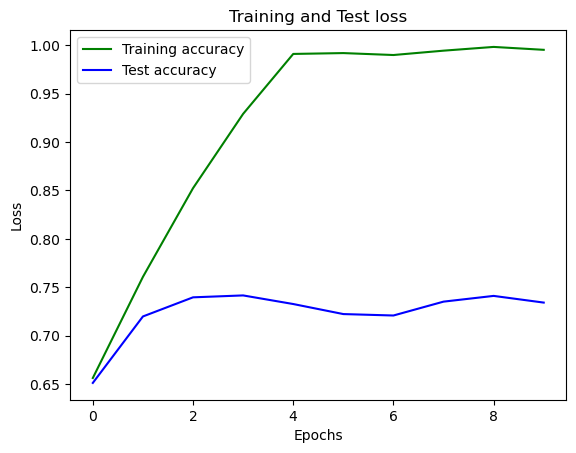

In [39]:
learning=1e-3

model=Net().to(DEVICE)

optimizer=optim.Adam(model.parameters(),lr=learning)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    print_plot=True,
    train_loader = train_loader,
    test_loader=test_loader
)

In [ ]:
from collections import OrderedDict

model=models.resnet50(pretrained= True)

for param in model.parameters():
    param.required_grad=False

nr_feat=model.fc.in_features
model.fc = nn.Sequential(OrderedDict([('fc',nn.Linear(nr_feat,1)),('sigmoid',nn.Sigmoid())]))


learning=0.01

model=model.to(DEVICE)
optimizer=optim.Adam(model.parameters(),lr=learning)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs=10,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    print_plot=True,
    train_loader = train_loader,
    test_loader=test_loader
)